In [23]:
import re
import random
import spacy

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.lines as lines
import matplotlib.text as text
import matplotlib.cm as cm
import seaborn as sns; sns.set()

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from catboost import CatBoostClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

import itertools
pd.options.display.width = 0
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 11)

spacy.prefer_gpu()
nlp = spacy.load("en_core_web_sm")
lemmatizer = nlp.get_pipe("lemmatizer")

In [73]:
df = pd.read_csv('./files/politifact_clean.csv')
print(df['veracity'].unique())

['Pants on Fire!' 'Mostly True' 'False' 'True' 'Mostly False']


In [74]:
df.head()

,statement,source,link,veracity
0,"Sen. Kamala Harris is ""supporting the animals ...",Donald Trump,/web/20180705082623/https://www.politifact.com...,Pants on Fire!
1,"Says Ronald Reagan said immigrants ""brought wi...",Becoming American Initiative,/web/20180705082623/https://www.politifact.com...,Mostly True
2,"Says Democratic Senators ""demand Supreme Court...",Viral image,/web/20180705082623/https://www.politifact.com...,Pants on Fire!
3,"""Tim Kaine doesn’t want a border at all. He wa...",Corey Stewart,/web/20180705082623/https://www.politifact.com...,Pants on Fire!
4,"""George H.W. Bush has died at 94.""",Bloggers,/web/20180705082623/https://www.politifact.com...,Pants on Fire!


veracity
False             2641
Mostly False      2335
Mostly True       2695
Pants on Fire!    1359
True              2158
Name: veracity, dtype: int64


<Axes: ylabel='veracity'>

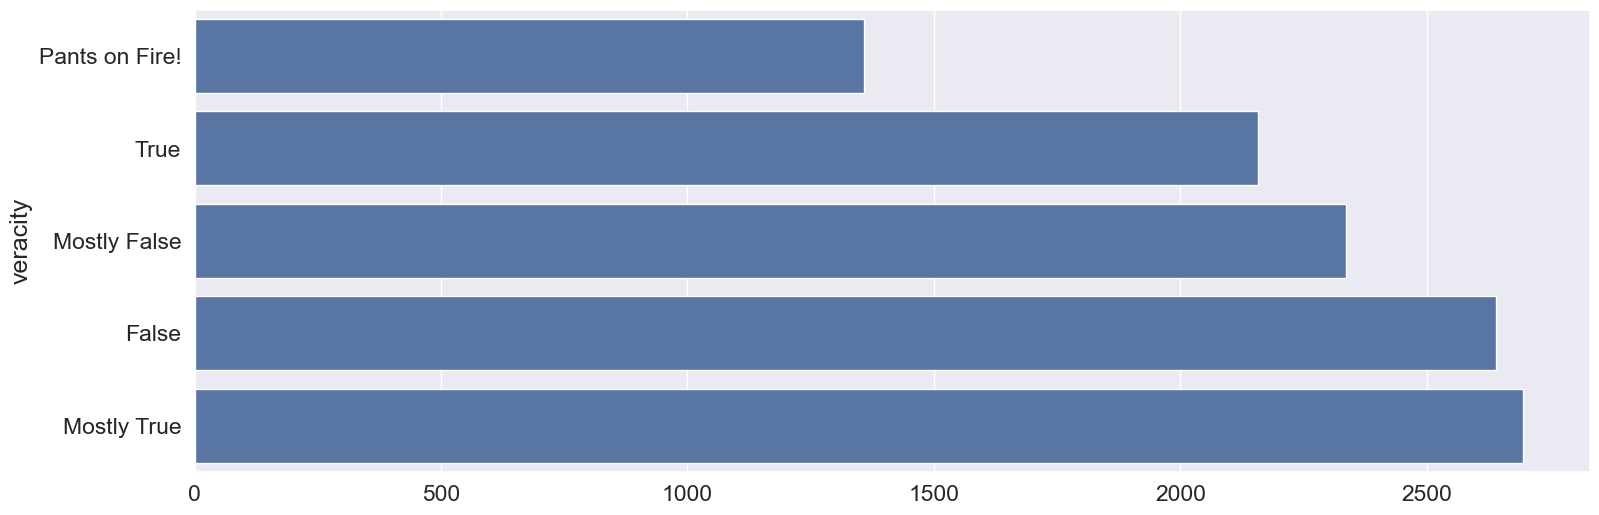

In [75]:
g = df.groupby('veracity')['veracity'].count().sort_values()
print(df.groupby('veracity')['veracity'].count())
sns.set(font_scale=1.5)
f, ax = plt.subplots(figsize=(18, 6))
sns.barplot(x = g.values, y = g.index, orient='h')

In [76]:
import string

def del_punct(str):
  for punctuation in string.punctuation:
    str = str.replace(punctuation, ' ')
  return str

    
def normtext(txt):
    '''
    Возвращает текст из слов в нормальной форме
    '''
    txt = txt.lower()
    txt = del_punct(txt)
    doc = nlp(txt)
    str1 = str(' '.join([token.lemma_ for token in doc if not token.is_stop]))
    str1 = re.sub(' +', ' ', str1)
    return str1

In [77]:
# cls_dic = {'Pants on Fire!':1,
#            'False':2,
#            'Mostly False':3,
#            'Mostly True':4,
#            'True':5,
#            }

cls_dic = {'Pants on Fire!':0,
           'False':0,
           'Mostly False':0,
           'Mostly True':1,
           'True':1,
           }

df['text'] = df.statement.map(lambda x: normtext(x))

df['class'] = df['veracity'].map(lambda x: cls_dic[x])

df.to_csv('./files/politifact_clean_with_lemmas.csv', index=False)

df.head()

,statement,source,link,veracity,text,class
0,"Sen. Kamala Harris is ""supporting the animals ...",Donald Trump,/web/20180705082623/https://www.politifact.com...,Pants on Fire!,sen kamala harris support animal ms 13,0
1,"Says Ronald Reagan said immigrants ""brought wi...",Becoming American Initiative,/web/20180705082623/https://www.politifact.com...,Mostly True,say ronald reagan say immigrant bring courag...,1
2,"Says Democratic Senators ""demand Supreme Court...",Viral image,/web/20180705082623/https://www.politifact.com...,Pants on Fire!,say democratic senator demand supreme court no...,0
3,"""Tim Kaine doesn’t want a border at all. He wa...",Corey Stewart,/web/20180705082623/https://www.politifact.com...,Pants on Fire!,tim kaine want border want rid immigration cu...,0
4,"""George H.W. Bush has died at 94.""",Bloggers,/web/20180705082623/https://www.politifact.com...,Pants on Fire!,george h w bush die 94,0


In [ ]:
# тут я разбирался как писать эту штуку
# doc = nlp("Apple, is looking at buying U.K. startup for $1 billion")

# filtered_tokens = [token.lemma_ for token in doc if not token.is_stop]
# print(filtered_tokens)

In [24]:
df = pd.read_csv('./files/politifact_clean_with_lemmas.csv')

X_train, X_test, y_train, y_test = train_test_split(df.text, df['class'], random_state=42, test_size=0.1, stratify=df['class'])

tfv = CountVectorizer(min_df = 0.01)  # Функция получения векторного представления
X_train = tfv.fit_transform(X_train)
X_test = tfv.transform(X_test)

param_grid_rf = {
    'n_estimators': [200],
    'max_depth': [10, 20],
    'min_samples_split': [5]
}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=3, scoring='f1_macro', n_jobs= -1)
grid_rf.fit(X_train, y_train)
grid_rf.score(X_test, y_test)
grid_rf.best_params_

{'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}

In [25]:
def predictor(text, clf, tfv):
    '''
    text - классифицируемый текс
    clf - обученный классификатор
    tfv - обученный векторизатор
    '''
    # Векторизация текста
    X_test = tfv.transform([text])

    # Предсказание с помощью модели
    pred = clf.predict(X_test)

    return pred[0]

def classifier():
    '''
    Создает классификатор
    '''

    tfv = CountVectorizer(min_df = 0.01)
    X = tfv.fit_transform(df.text)
    y = df['class']
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1, stratify=y)

    # Обучение модели (RF) на расширенных данных
    # clf2 = RandomForestClassifier(random_state=42, max_depth=20, min_samples_split = 5, n_estimators = 200)
    # clf2.fit(X_train, y_train)

    param_grid_rf = {
        'n_estimators': [1, 20, 42, 88, 200],
        'max_depth': [3, 5, 7, 10, 15, 20],
        'min_samples_split': [5, 10],
        'criterion' : ['gini', 'entropy'],
    }
    grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=3, scoring='f1_macro', n_jobs= -1)
    grid_rf.fit(X_train, y_train)
    grid_rf.score(X_test, y_test)

    # Оценка каскадной модели
    accuracy = grid_rf.best_estimator_.score(X_test, y_test)
    print(f'Accuracy of rf model: {accuracy}')

    return tfv, grid_rf.best_estimator_ 

In [26]:
# Обучение

X_train, X_test, y_train, y_test = train_test_split(df['text'], df['class'], random_state=42, test_size=0.15, stratify=df['class'])

tfv, clf = classifier()


Accuracy of rf model: 0.646112600536193


In [27]:
# # Предсказание
pred_save = []
class_save = []
pred = []
print(X_test.shape)
# X = tfv.fit_transform(df.text)
for nom, txt in enumerate(X_test.values):
    pred.append(predictor(txt, clf, tfv))
print(X_test.shape)

(1679,)
(1679,)


In [28]:
cls_dic = {0:'False',
           1:'True',
           }

y_test_list = y_test.tolist()
y_test_list.extend(class_save)
pred_list = pred[:]
pred_list.extend(pred_save)

mtrs = classification_report([cls_dic[x] for x in y_test_list], [cls_dic[x] for x in pred_list])
print(mtrs)

              precision    recall  f1-score   support

       False       0.65      0.86      0.74       951
        True       0.69      0.40      0.51       728

    accuracy                           0.66      1679
   macro avg       0.67      0.63      0.63      1679
weighted avg       0.67      0.66      0.64      1679



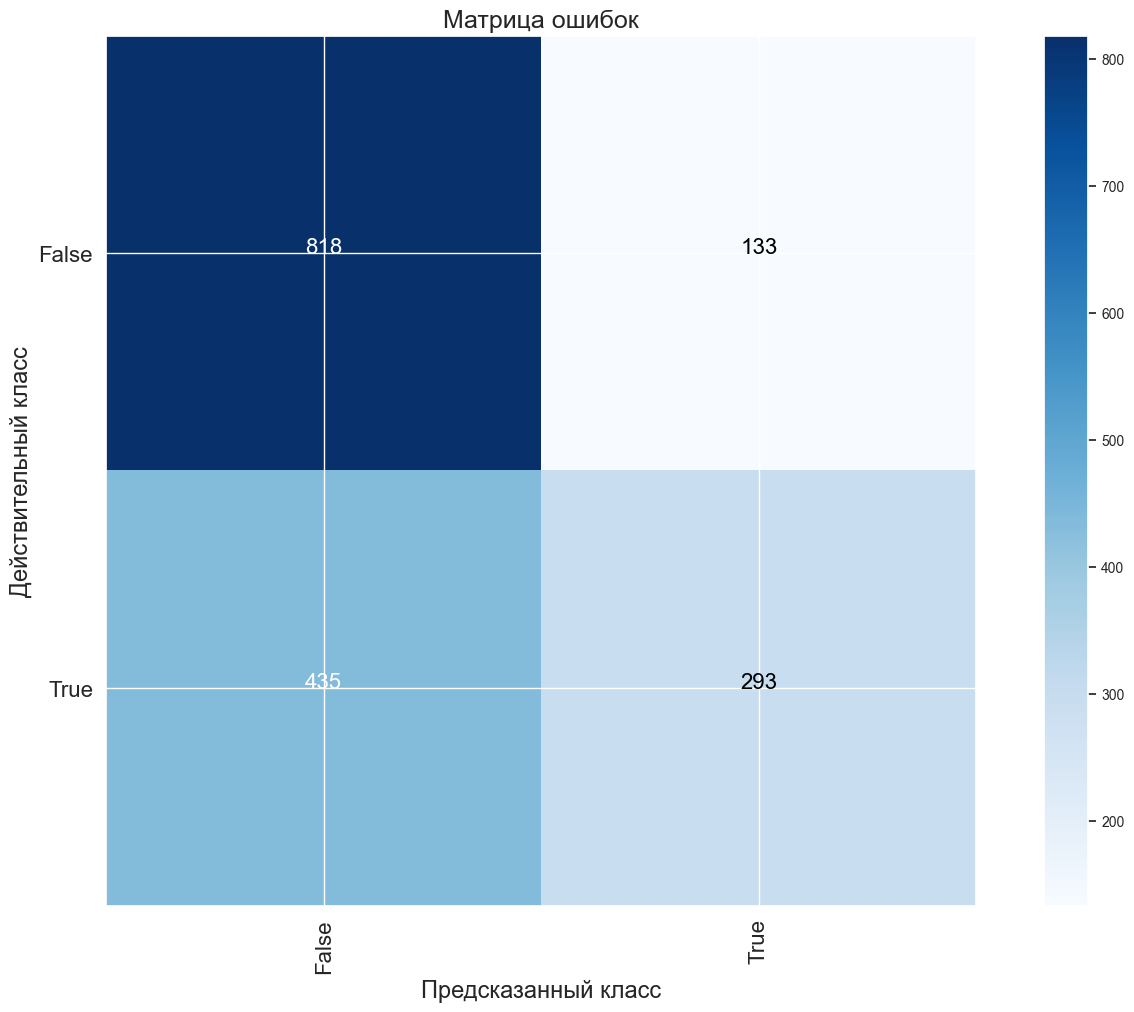

In [29]:
def plot_confusion_matrix(cm, classes, f_size=16, normalize=False, title='Матрица ошибок', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting 'normalize=True'
    """
    plt.figure(figsize=(14,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=f_size + 2)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=f_size - 6)

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=f_size)
    plt.yticks(tick_marks, classes, fontsize=f_size)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        pass
        #print("Confusion matrix, without normalization")

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=f_size)
    plt.tight_layout()
    plt.ylabel('Действительный класс', fontsize=f_size + 1)
    plt.xlabel('Предсказанный класс', fontsize=f_size + 1)
    plt.show()

# conf_matr = confusion_matrix(y_test_list, pred_list, normalize='true')
cls_list = []
for i in range(0,len(cls_dic)):
  cls_list.append(cls_dic[i])
conf_matr = confusion_matrix(y_test_list, pred_list)
plot_confusion_matrix(conf_matr, cls_list,  f_size=16)